# Behavioral cloning project
In this project, we will make a car drive on its own in a simulated environment. The simulator is provided by Udacity's Self Driving Car Nano Degree program. 

### Goal:
Build a model that takes images as "seen" by three cameras mounted on the car and predict an appropriate steering anlge to autonomously drive on a simulated track.

In [1]:
import pandas as pd
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.utils import shuffle

In [2]:
g_initial_img_shape = None
g_initial_num_images = None
g_batch_size = None
g_top_rows_to_crop = None
g_bottom_rows_to_crop = None
g_processed_img_height = None
g_processed_img_width = None
g_processed_img_channels = None
g_left_angle_offset = None
g_right_angle_offset = None

### Data exploration

In [3]:
img_folder = './data/IMG/'
csv_file_path = './data/driving_log.csv'
csv_file_path_without_header = './data/driving_log_without_header.csv'
df = pd.read_csv(csv_file_path)
df.head(5)

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


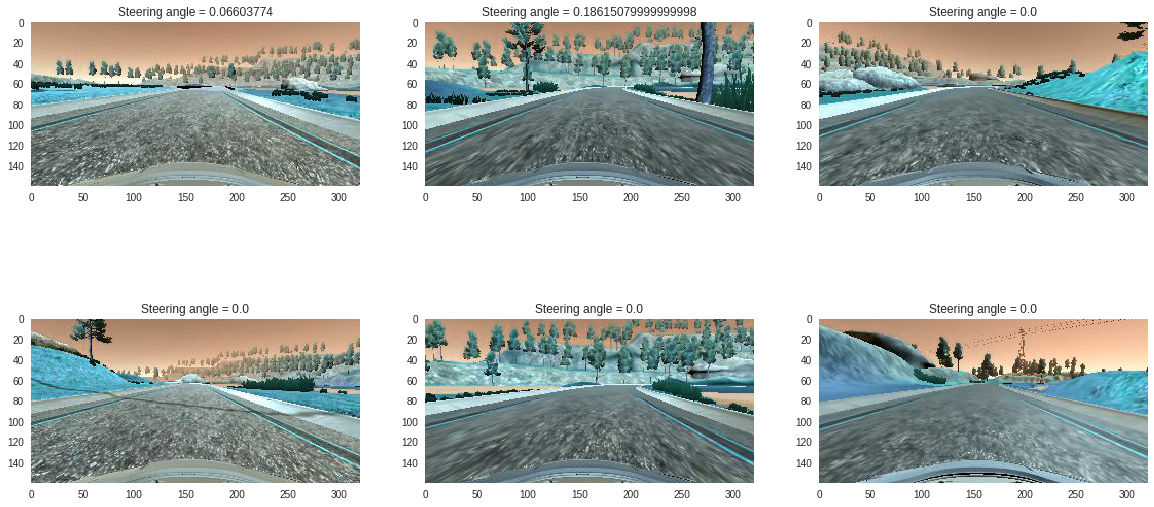

In [32]:
# Look at some images

fig = plt.figure(figsize=(20, 10))
number_of_images = 6
for i in range(number_of_images):
    image_index = np.random.randint(0, df.shape[0] - 1)
    image_file_path = df.iloc[image_index]["center"].split('/')[-1]
    steering_angle = df.iloc[image_index]["steering"]
    img = cv2.imread(img_folder + image_file_path)
    ax = fig.add_subplot(2, number_of_images/2, i+1)
    ax.set_title("Steering angle = {}".format(steering_angle))
    ax.grid(False) 
    ax.imshow(img)
fig.savefig('./images_writeup/sample_images.png')
plt.show()

In [14]:
sample_image_path = img_folder + 'center_2016_12_01_13_30_48_287.jpg'
print("Image size = {0: .1f} Kb".format(os.stat(sample_image_path).st_size/1024))
print("Approx total datasize = {0: .1f} Mb".format(3*len(df)*os.stat(sample_image_path).st_size/(1024*1024)))
print("Shape of image = {}".format(cv2.imread(sample_image_path).shape))
print("Total number of center images = {}".format(len(df)))

Image size =  14.4 Kb
Approx total datasize =  470.9 Mb
Shape of image = (160, 320, 3)
Total number of center images = 11175


Observations:


### Basic statistics

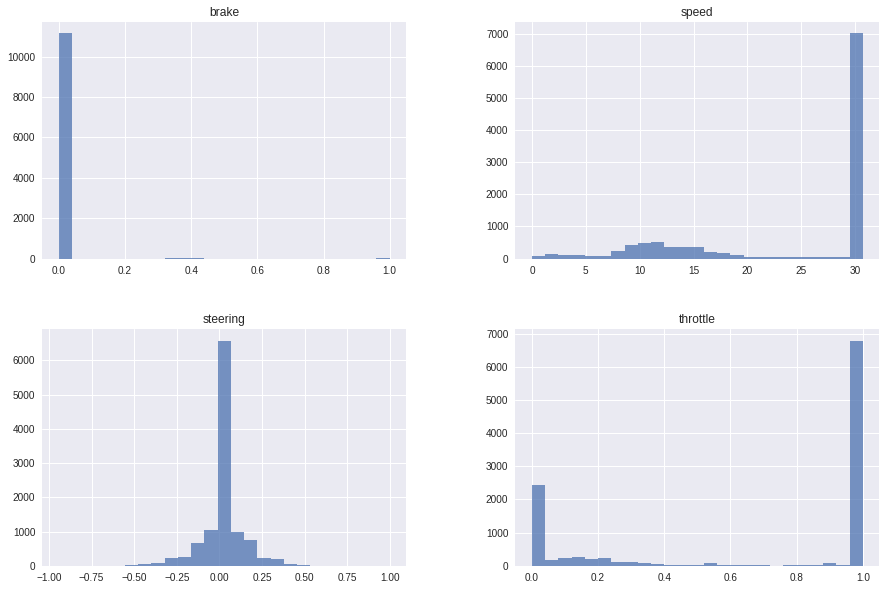

Basic stats
           steering      throttle         brake         speed
count  11175.000000  11175.000000  11175.000000  1.117500e+04
mean       0.011496      0.654506      0.001416  2.361964e+01
std        0.124146      0.436057      0.031019  9.212323e+00
min       -0.942695      0.000000      0.000000  3.570085e-07
25%        0.000000      0.115796      0.000000  1.438348e+01
50%        0.000000      0.985533      0.000000  3.018483e+01
75%        0.047170      0.985533      0.000000  3.018662e+01
max        1.000000      1.000000      1.000000  3.070936e+01


Correlation
          steering  throttle     brake     speed
steering  1.000000 -0.100834 -0.023993 -0.100970
throttle -0.100834  1.000000 -0.068548  0.904693
brake    -0.023993 -0.068548  1.000000 -0.052133
speed    -0.100970  0.904693 -0.052133  1.000000


In [22]:
df.hist(alpha=0.75, bins=25, figsize=(15,10))
plt.savefig('./images_writeup/features_stats.png')
plt.show()
print("Basic stats")
print(df.describe())

print()
print()

print("Correlation")
print(df.corr())

Observations:


Rebember that the throttle will be set in the project and it is not something that needs to be set by the model. 

### Initial processing
```
Preprocessing steps:
1) Take only the center image
2) Crop the bottom part of the image
3) Crop the top part of the image
4) Convert the image to gray scale
5) Apply gaussian blur
6) Apply Canny edge detection
```

```
Things to keep in mind:
1) Keras Lambda layers for preprocessing
2) Keras Cropping2D for cropping images
3) fit_generator to see history for training/validation loss
4) Generators to yield images
```

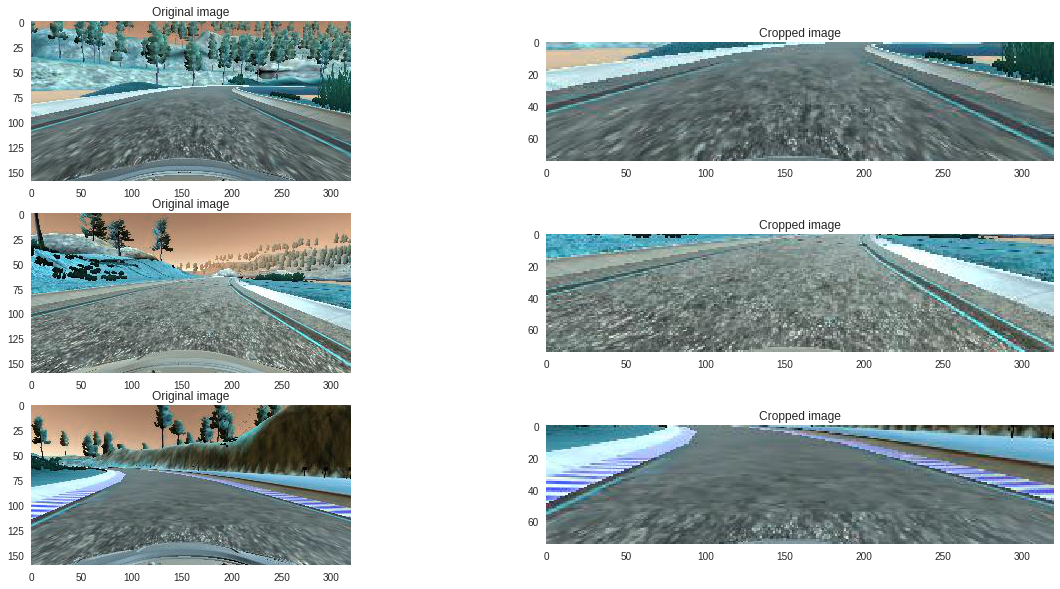

In [4]:
# Cropping

g_top_rows_to_crop = 65
g_bottom_rows_to_crop = 20

fig = plt.figure(figsize=(20, 10))
number_of_images = 3
ax_index = 0
for _ in range(number_of_images):
    
    image_index = np.random.randint(0, df.shape[0] - 1)
    image_file_path = df.iloc[image_index]["center"].split('/')[-1]
    steering_angle = df.iloc[image_index]["steering"]
    img = cv2.imread(img_folder + image_file_path)
    cropped_img = img[g_top_rows_to_crop:img.shape[0]-g_bottom_rows_to_crop,]
    
    ax = fig.add_subplot(number_of_images, 2, ax_index+1)
    ax.set_title("Original image")
    ax.grid(False) 
    ax.imshow(img)
    
    ax = fig.add_subplot(number_of_images, 2, ax_index+2)
    ax.set_title("Cropped image")
    ax.grid(False) 
    ax.imshow(cropped_img)
    
    ax_index += 2
plt.savefig('./images_writeup/cropped_images.png')
plt.show()

In [5]:
def get_cropped_image(img, up=g_top_rows_to_crop, down=g_bottom_rows_to_crop):
    """
    Crop image from top and bottom. 
    Assumes that the shape of the image is in the form (height, width, color channels)
    """
    return img[up:img.shape[0]-down,]

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def histogram_equal(img):
    """
    Improves the contrast of the image
    """
    return cv2.equalizeHist(img)


def process_image(img):
    
    # Make a copy of the image
    image = np.copy(img)
    
    # Cropped image
    image = get_cropped_image(image)
    
    # Convert the copy_image to grayscale
    image = grayscale(image)
    
    # gausian filtering
    #kernal_size = 5
    #image = gaussian_blur(image, kernal_size)
    
    # Hist equalization
    image = histogram_equal(image)
    
    # Normalize
    image = (image - image.mean()) * 1. /image.std()
    
    return image

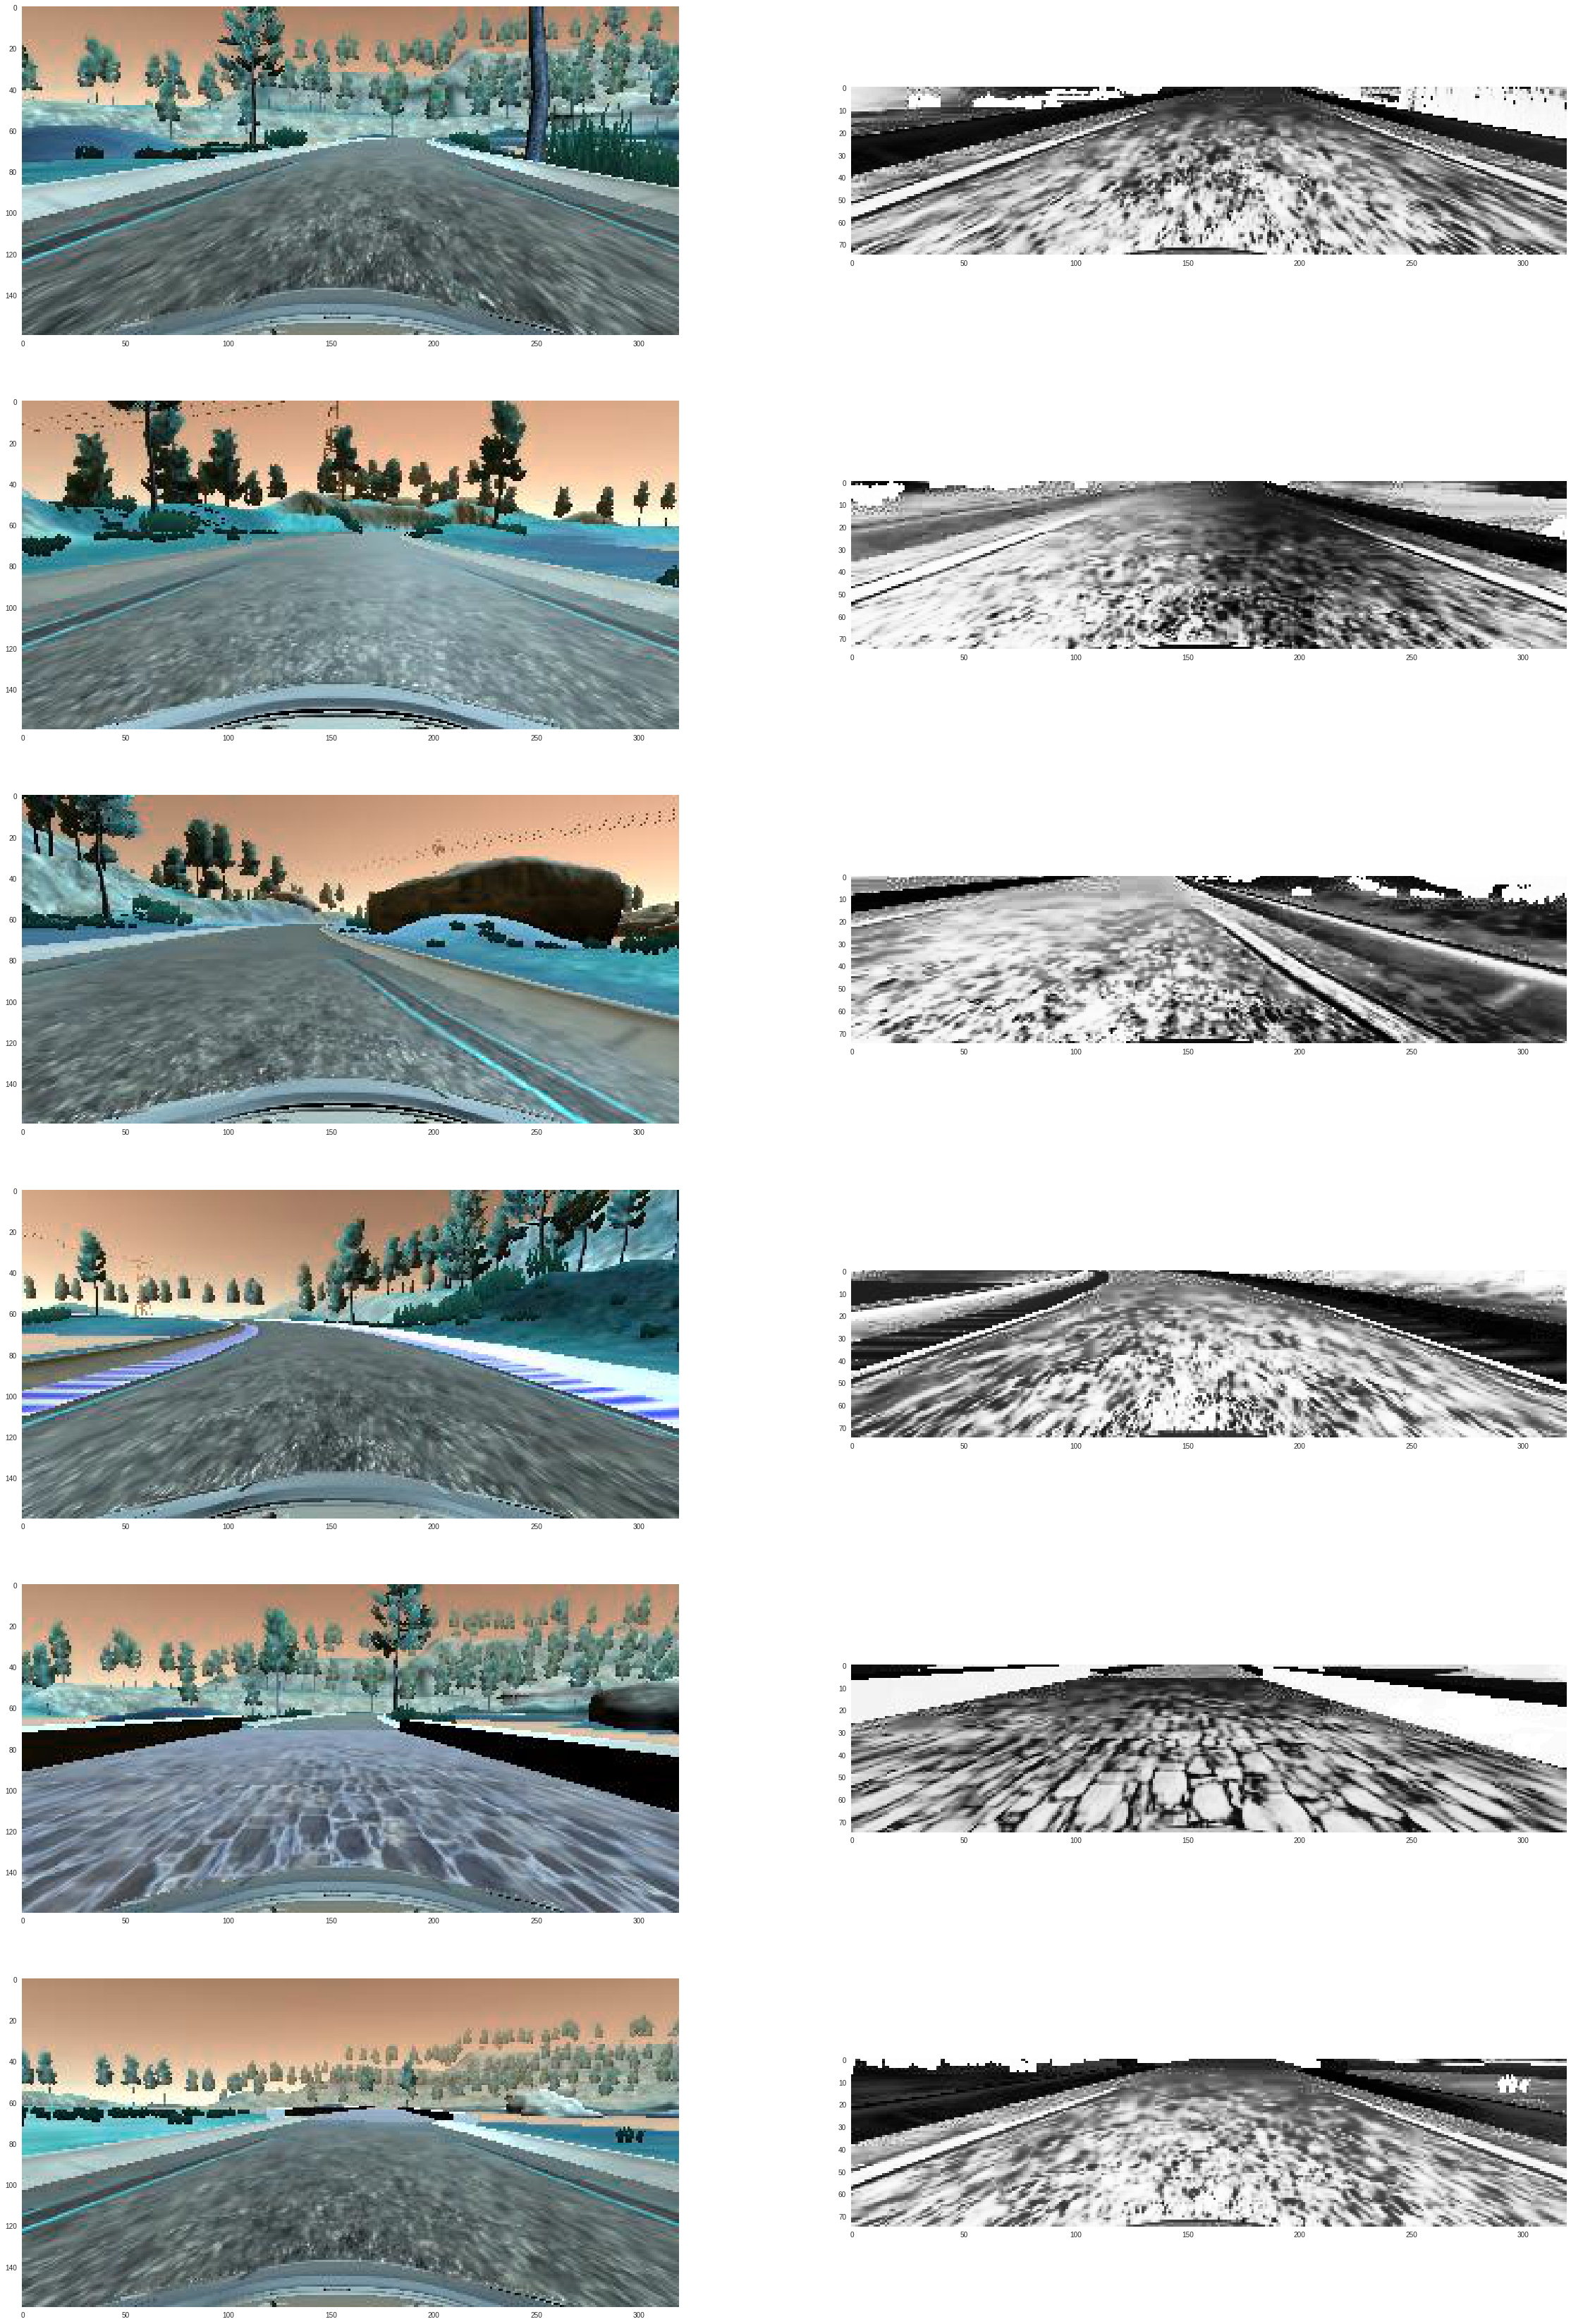

In [8]:
fig = plt.figure(figsize=(40, 60))
number_of_images = 6
ax_index = 0
for _ in range(number_of_images):
    
    image_index = np.random.randint(0, df.shape[0] - 1)
    image_file_path = df.iloc[image_index]["center"].split('/')[-1]
    steering_angle = df.iloc[image_index]["steering"]
    img = cv2.imread(img_folder + image_file_path)
    processed_img = process_image(img)
    
    ax = fig.add_subplot(number_of_images, 2, ax_index+1)
    ax.grid(False) 
    ax.imshow(img)
    
    ax = fig.add_subplot(number_of_images, 2, ax_index+2)
    ax.grid(False) 
    ax.imshow(processed_img)
    
    ax_index += 2
plt.savefig('./images_writeup/processed_images.png')
plt.show()

In [9]:
# Set the processed image height/width/channels
sample_image_path = img_folder + 'center_2016_12_01_13_30_48_287.jpg'
processed_img = process_image(cv2.imread(sample_image_path))
g_processed_img_height = processed_img.shape[0]
g_processed_img_width = processed_img.shape[1]
g_processed_img_channels = 1 if len(processed_img.shape) == 2 else processed_img.shape[2]

print("Processed image shape = ({0}x{1}x{2})".format(g_processed_img_height, 
                                                    g_processed_img_width, 
                                                    g_processed_img_channels))

Processed image shape = (75x320x1)


In [337]:
# Augment images

for i in range(len(df)):
    
    center_image_file_path = df.iloc[i]["center"].split('/')[1]
    left_image_file_path = df.iloc[i]["left"].split('/')[1]
    right_image_file_path = df.iloc[i]["right"].split('/')[1]
    
    center_img = cv2.imread(img_folder + center_image_file_path)
    left_img = cv2.imread(img_folder + left_image_file_path)
    right_img = cv2.imread(img_folder + right_image_file_path)
    
    center_flipped_img = cv2.flip( center_img, 0 )
    left_flipped_img = cv2.flip( left_img, 0 )
    right_flipped_img = cv2.flip( right_img, 0 )
    
    center_flipped_image_file_path = img_folder + 'flipped_' + center_image_file_path
    left_flipped_image_file_path = img_folder + 'flipped_' + left_image_file_path
    right_flipped_image_file_path = img_folder + 'flipped_' + right_image_file_path
    
    cv2.imwrite(center_flipped_image_file_path,center_flipped_img)
    cv2.imwrite(left_flipped_image_file_path,left_flipped_img)
    cv2.imwrite(right_flipped_image_file_path,right_flipped_img)
    
    flipped_steering_angle = -1 * df.iloc[i]["steering"]
    
    fields = [center_flipped_image_file_path, 
              left_flipped_image_file_path, 
              right_flipped_image_file_path, flipped_steering_angle, 
              df.iloc[i]["throttle"], 
              df.iloc[i]["brake"], df.iloc[i]["speed"]]
    
    with open(r'./driving_log_without_header.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(fields)

### Model

In [338]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras import backend as K

In [344]:
g_batch_size = 32
g_left_angle_offset = 0.25
g_right_angle_offset = -0.25

samples = []
with open(csv_file_path_without_header) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
                
def generator(samples, batch_size=g_batch_size):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        #samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            begin = offset
            end = begin + batch_size
            batch_samples = samples[begin:end]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # center
                center_image_name = img_folder + batch_sample[0].split('/')[-1]
                center_image = cv2.imread(center_image_name)
                center_angle = float(batch_sample[3])
                
                processed_center_image = process_image(center_image) 
                if len(processed_center_image.shape) == 2:
                    processed_center_image = np.array(processed_center_image).reshape(processed_center_image.shape[0], 
                                                                                      processed_center_image.shape[1], 
                                                                                      1)
                images.append(processed_center_image)
                angles.append(center_angle)
                
                # left
                left_image_name = img_folder + batch_sample[1].split('/')[-1]
                left_image = cv2.imread(left_image_name)
                left_angle = float(batch_sample[3]) + g_left_angle_offset
                
                processed_left_image = process_image(left_image) 
                if len(processed_left_image.shape) == 2:
                    processed_left_image = np.array(processed_left_image).reshape(processed_left_image.shape[0], 
                                                                                  processed_left_image.shape[1], 
                                                                                  1)
                images.append(processed_left_image)
                angles.append(left_angle)

                # right
                right_image_name = img_folder + batch_sample[2].split('/')[-1]
                right_image = cv2.imread(right_image_name)
                right_angle = float(batch_sample[3]) + g_right_angle_offset
                
                processed_right_image = process_image(right_image) 
                if len(processed_right_image.shape) == 2:
                    processed_right_image = np.array(processed_right_image).reshape(processed_right_image.shape[0], 
                                                                                    processed_right_image.shape[1], 
                                                                                    1)
                images.append(processed_right_image)
                angles.append(right_angle)

                

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            #print("X_train.shape = ", X_train.shape)
            yield shuffle(X_train, y_train)       
            
# define training and validation generator functions
train_generator = generator(train_samples, batch_size=g_batch_size)
validation_generator = generator(validation_samples, batch_size=g_batch_size)

In [345]:
"""
for i in range(1):
    my_output = next(train_generator)
    print(my_output[0].shape)
    print(my_output[1].shape)
"""


'\nfor i in range(1):\n    my_output = next(train_generator)\n    print(my_output[0].shape)\n    print(my_output[1].shape)\n'

In [341]:
in_shape = None
if K.image_dim_ordering() == 'th':
    in_shape = (g_processed_img_channels, g_processed_img_height, g_processed_img_width)
else:
    in_shape = (g_processed_img_height, g_processed_img_width, g_processed_img_channels)

"""    
model = Sequential()
model.add(Conv2D(12, 3, 3,
                 activation='relu', 
                 input_shape=in_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(24, 3, 3,
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))
"""

model = Sequential()
model.add(Conv2D(24, 5, 5, activation='elu', input_shape=in_shape, subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
#model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()




model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), 
                                     validation_data=validation_generator,
                                     nb_val_samples=len(validation_samples), nb_epoch=3, 
                                     verbose=1)

model.save('model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_122 (Convolution2D (None, 36, 158, 24)   624         convolution2d_input_53[0][0]     
____________________________________________________________________________________________________
convolution2d_123 (Convolution2D (None, 16, 77, 36)    21636       convolution2d_122[0][0]          
____________________________________________________________________________________________________
convolution2d_124 (Convolution2D (None, 6, 37, 48)     43248       convolution2d_123[0][0]          
____________________________________________________________________________________________________
convolution2d_125 (Convolution2D (None, 4, 35, 64)     27712       convolution2d_124[0][0]          
___________________________________________________________________________________________

In [342]:
print(history_object.history.keys())

dict_keys(['val_loss', 'loss'])


In [343]:
train_steering_angles = [float(record[3]) for record in train_samples]
validation_steering_angles = [float(record[3]) for record in validation_samples]

train_R_squared = 1 - (history_object.history['loss']/np.std(train_steering_angles))
validation_R_squared = 1 - (history_object.history['val_loss']/np.std(validation_steering_angles))

print("train_R_squared = {}".format(train_R_squared))
print("validation_R_squared = {}".format(validation_R_squared))

train_R_squared = [ 0.75901544  0.90987935  0.92541382]
validation_R_squared = [ 0.90165618  0.92091469  0.92241117]
